# Tutorial 5 - Automated sleep staging

Original author: [Santeri Rytky](https://www.oulu.fi/fi/tutkijat/santeri-rytky) 

Human brain is a complex system consisting of millions of neurons. With electroencephalography (EEG), it is possible to measure the electrical sum signals of the neurons by attaching electrodes to the scalp. The method is often used in hospitals to monitor sleep, effect of anesthesia, as well as diagnosing sleep disorders and epilepsy. 

Polysomnography (PSG), a sleep study, includes EEG measurements as well as measurements for eye movement (EOG), muscle movement (EMG), heart (ECG), airflow, pulse oximetry and snore. This allows complementing the brain signals with other physiological information.

The dataset used in this tutorial is collected in University of Coimbra, Portugal. The dataset can be accessed here: https://sleeptight.isr.uc.pt/. For more information on analysis of the specific dataset, please refer to https://doi.org/10.1016/j.cmpb.2015.10.013.

Topics covered:
- Conducting machine learning experiments on sleep measurements (or any other signal-based data).
- Cross-validation accounting for the patient index
- Feature extraction to avoid overfitting
- Oversampling to account class imbalance
- Comparing different models using statistical methods
- What score is good enough? Comparison to human level accuracy

In [ ]:
'''
# Mount the Google drive folder to Colab
from google.colab import drive
drive.mount('/content/drive')

import sys
path = '/content/drive/My Drive/MLinMedicine/Tutorial5/'
sys.path.append(path)
''';

In [ ]:
# Extract the data folder (quietly). If you have already extracted, select N
#!unzip -q '/content/drive/My Drive/MLinMedicine/Tutorial5/Sleep_data.zip' -d '/content/drive/My Drive/MLinMedicine/Tutorial5/Sleep_data'

In [ ]:
# !pip install -q imbalanced-learn scikit-learn==1.4.2

<font size="5">Note that you need to unzip the "Sleep_data.zip" manually if you are using windows. The unzip command should work on linux.</font>

In [2]:
# Use ctrl to see details

import os  # Operating system functions
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Timing and dates
import time

# Save and load data
import h5py

# Signal processing
from scipy.fft import rfft, rfftfreq
from scipy.signal import periodogram
from scipy.stats import skew, kurtosis, wilcoxon

# Scikit-learn
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import clone  # Copy a model architecture
from sklearn.metrics import (confusion_matrix,
    accuracy_score,
    average_precision_score, precision_recall_curve,
    roc_curve, roc_auc_score,
    classification_report
)


# SMOTE: Synthetic Minority Over-sampling Technique
from imblearn.over_sampling import SMOTE

# 1. Data loading and preprocessing

Let's start by loading the dataset, including polysomnography (PSG) measurements (signals) from 10 controls and 9 patients. All measurements include sleep stages scored by two human experts (labels).

The measurements are downsampled from 200Hz to 100Hz to save memory. The sleep measurements are often divided to 30s segments, **epochs**. In this case, only every 6th epoch is included (30s segment every 3 minutes). Signals include a total of 100 epochs/patient, meaning that 5 hours are included in the measurements.

In [3]:
# Load data with h5py
path = './Sleep_data/'

# List measurements
samples = os.listdir(path)
samples.sort()
print(samples)

# Load the sleep measurements and expert labels
# Data is stored in variables named as "signals" and "labels"
data_c, labels_c, data_p, labels_p = [], [], [], []
for sample in samples:
    # Control
    if 'control' in sample:
        with h5py.File(path + sample, 'r') as f:
            data_c.extend(f['signals'][:])
            labels_c.extend(f['labels'][:])
    # Patient
    elif 'patient' in sample:
        with h5py.File(path + sample, 'r') as f:
            data_p.extend(f['signals'][:])
            labels_p.extend(f['labels'][:])
    # Not accounted for
    else:
        print(f'{sample} is not a sleep measurement!')

# Convert to Numpy array
data_c = np.array(data_c)
labels_c = np.array(labels_c)
data_p = np.array(data_p)
labels_p = np.array(labels_p)

['controls_0.h5', 'controls_1.h5', 'controls_2.h5', 'controls_3.h5', 'controls_4.h5', 'patients_0.h5', 'patients_1.h5', 'patients_2.h5', 'patients_3.h5', 'patients_4.h5']


We can visualize some of the sleep measurements.

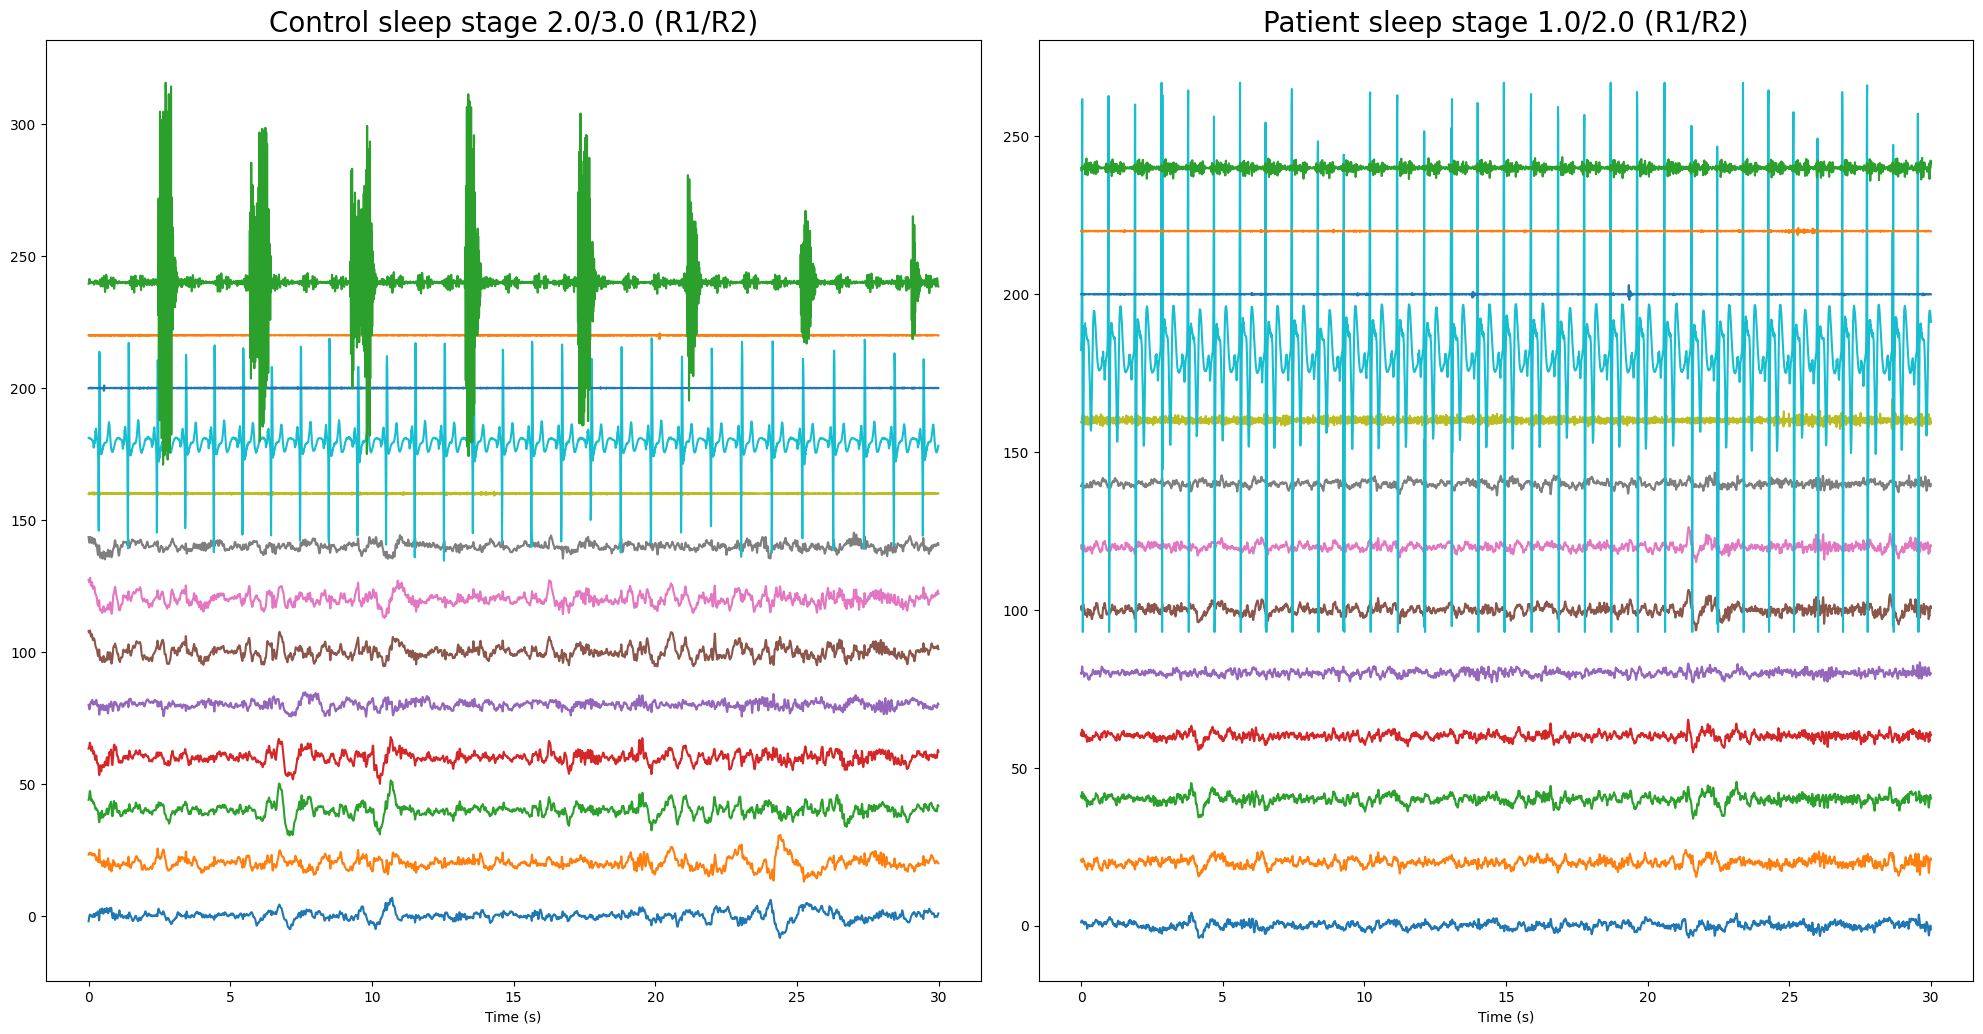

Study is 100.0 epochs long.


In [4]:
# General variables
e_length = 30
sampling_frequency = 100
n_ch = 13

# Plot a specific epoch
ID = 3
epoch = 30
t0 = sampling_frequency * e_length * epoch
t1 = sampling_frequency * e_length + t0

time_axis = np.linspace(0.0, e_length, e_length*sampling_frequency, endpoint=False)

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
plt.tight_layout()

# Plot control
for i in range(data_c[ID].shape[0]):
    axs[0].plot(time_axis, data_c[ID][i, t0:t1] + i * 20)
axs[0].set_title(f'Control sleep stage {labels_c[ID][0][epoch]}/{labels_c[ID][1][epoch]} (R1/R2)', fontsize=20)
axs[0].set_xlabel('Time (s)')

# Plot patient
for i in range(data_p[ID].shape[0]):
    axs[1].plot(time_axis, data_p[ID][i, t0:t1] + i * 20)
axs[1].set_title(f'Patient sleep stage {labels_p[ID][0][epoch]}/{labels_p[ID][1][epoch]} (R1/R2)', fontsize=20)
axs[1].set_xlabel('Time (s)')
plt.show()

# Number of epochs
print(f'Study is {data_c[ID].shape[1] / sampling_frequency / e_length} epochs long.')

As we can see from the above figure, the PSG measurement consists of 13 individual channels (counting from bottom to up):
- 2 EOG measurements (left and right eye movement)
- 6 EEG measurements (reference measurement from ear-lobes)
- Chin EMG (muscle activation, between the chin and lower lip)
- ECG (electrocardiography, heart signal)
- Leg EMG (left and right leg muscle activation)
- Snore (sound)

You can visualize other signals by changing **ID/epoch** values in the above script.

We can also identify the sleep stages included for each patient:

In [5]:
# Print the unique sleep stage labels for each patient, and the number of epochs
print('Controls')
for i in range(len(labels_c)):
    print(f'Control {i}, reader {1}', np.unique(labels_c[i][0]))
    print(f'Control {i}, reader {2}', np.unique(labels_c[i][1]))
    print(f'Study is {data_c[i].shape[1] / sampling_frequency / e_length} epochs long.')

print('\nPatients')
for i in range(len(labels_p)):
    print(f'Patient {i}, reader {1}', np.unique(labels_p[i][0]))
    print(f'Patient {i}, reader {2}', np.unique(labels_p[i][1]))
    print(f'Study is {data_p[i].shape[1] / sampling_frequency / e_length} epochs long.')

Controls
Control 0, reader 1 [0. 1. 2. 3. 5.]
Control 0, reader 2 [0. 1. 2. 3. 5.]
Study is 100.0 epochs long.
Control 1, reader 1 [0. 1. 2. 3. 5.]
Control 1, reader 2 [0. 1. 2. 3. 5.]
Study is 100.0 epochs long.
Control 2, reader 1 [0. 1. 2. 3. 5.]
Control 2, reader 2 [0. 1. 2. 3. 5.]
Study is 100.0 epochs long.
Control 3, reader 1 [0. 1. 2. 3. 5.]
Control 3, reader 2 [0. 1. 2. 3. 5.]
Study is 100.0 epochs long.
Control 4, reader 1 [0. 1. 2. 3. 5.]
Control 4, reader 2 [0. 1. 2. 3. 5.]
Study is 100.0 epochs long.
Control 5, reader 1 [0. 1. 2. 3. 5.]
Control 5, reader 2 [0. 1. 2. 3. 5.]
Study is 100.0 epochs long.
Control 6, reader 1 [0. 1. 2. 3. 5.]
Control 6, reader 2 [0. 1. 2. 3. 5.]
Study is 100.0 epochs long.
Control 7, reader 1 [0. 1. 2. 3. 5.]
Control 7, reader 2 [0. 1. 2. 3. 5.]
Study is 100.0 epochs long.
Control 8, reader 1 [0. 1. 2. 3. 5.]
Control 8, reader 2 [0. 1. 2. 3. 5.]
Study is 100.0 epochs long.
Control 9, reader 1 [0. 1. 2. 3. 5.]
Control 9, reader 2 [0. 1. 2. 3. 5.]

We can see that **patients 5 and 6 are missing the REM-sleep stage**. We can also confirm that 100 epochs are included from each patient.

We can plot a histogram from the labels to see the actual distributions of each sleep stage.

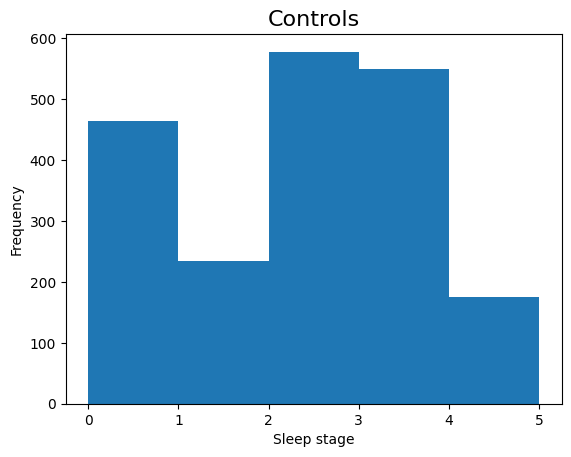

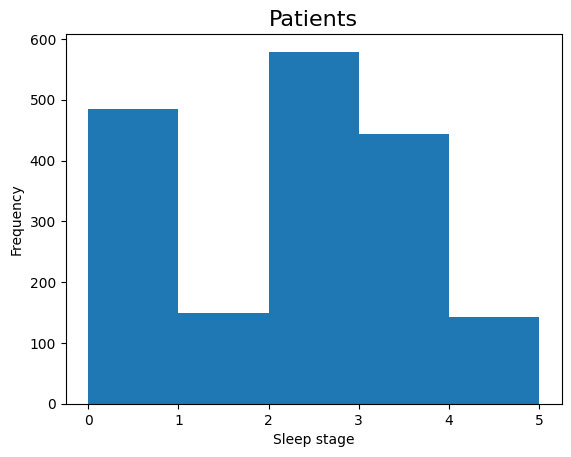

In [6]:
# Histogram for sleep stage frequencies

# Control
plt.hist(labels_c.ravel(), bins=5)
plt.title('Controls', fontsize=16)
plt.xlabel('Sleep stage')
plt.ylabel('Frequency')
plt.show()

# Patient
plt.hist(labels_p.ravel(), bins=5)
plt.title('Patients', fontsize=16)
plt.xlabel('Sleep stage')
plt.ylabel('Frequency')
plt.show()

Based on the above histogram, we can see that the N1- and REM-stages are the least represented stages in the dataset.

# 2. Split data

In the first experiment, we will try to predict the sleep stage based on the expert scores. Next, we will split the data into training and testing. For classifying the sleep stages, we can train on the healthy controls and test on the patients with sleep disorder. Another option would be to mix some of the controls and patients to the training set, possibly allowing for a more general model. 

For the labels, we will use readings from expert 1. Another possibility would be using a regression model, predicting the average grade. This would allow an "intermediate" class to be predicted as well.

An important note is that we will account for the patient ID when splitting the folds. This means that signals from the same patient are only included in one of the training, validation and testing folds.

In [7]:
# Separate epochs. 1 epoch = 1 sample. -1 denotes the residual shape
X_train = np.reshape(data_c, (len(data_c), n_ch, -1, e_length * sampling_frequency))
X_test = np.reshape(data_p, (len(data_p), n_ch, -1, e_length * sampling_frequency))

# Swap the channel and patient dimension
X_train = X_train.transpose(1, 0, 2, 3)
X_test = X_test.transpose(1, 0, 2, 3)
print('Channels, patients, epochs, t', X_train.shape)

# Combine patient dimension. This is accounted by the groups variable.
X_train = X_train.reshape((X_train.shape[0], -1, X_train.shape[-1]))
X_train = X_train.transpose(1, 0, 2)

X_test = X_test.reshape((X_test.shape[0], -1, X_test.shape[-1]))
X_test = X_test.transpose(1, 0, 2, )
print('Samples, channels, t', X_train.shape)

# Same shape for the labels
Y_train = labels_c[:, 0, :]
Y_test = labels_p[:, 0, :].flatten()

# Group IDs
groups = np.zeros(Y_train.shape)
for p in range(groups.shape[0]):
    groups[p] += p

# Flatten the patient dimension
groups = groups.flatten()
Y_train = Y_train.flatten()
print('Shape for labels and groups: ', groups.shape, Y_train.shape)

Channels, patients, epochs, t (13, 10, 100, 3000)
Samples, channels, t (1000, 13, 3000)
Shape for labels and groups:  (1000,) (1000,)


Next, we will do the training and validation split for the sleep staging data. Note that we will use the groups variable and **GroupShuffleSplit** class to make sure that training and validation folds do not include epochs from the same patient.

In [8]:
# Fix the random seed for consistent experiments
seed = 5

# Save the full training/validation data
X_Train, Y_Train = X_train[:], Y_train[:]

# Split training and validation
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=seed)
gss.get_n_splits()
for train_idx, val_idx in gss.split(X_train, Y_train, groups):
    X_val, Y_val = X_train[val_idx], Y_train[val_idx]
    X_train, Y_train = X_train[train_idx], Y_train[train_idx]

print(f'The data includes {X_train.shape[0]} training samples and {X_val.shape[0]} validation samples')

The data includes 700 training samples and 300 validation samples


# 3. Sleep staging: model training

In the tutorial, we will use a **Gradient boosting machine (GBM)** classifier, a powerful **ensemble** model. Similar to **Random forest**, GBM is built of multiple **decision trees**. The input features are passed through the decision trees and ultimately end up in one of the output nodes corresponding to the output class. Contrary to the random forest where trees are independent from each other, GBM adds multiple weak decision trees based on the model training.

To start with, we have a Gradient boosting machine with default parameters. We simply input the **full measurement from all 13 channels** to the model. Since one epoch is 30 seconds, with 100Hz sampling frequency, there are a total of **39 000 features**. To create the feature vector, we need to reshape the data properly. **The model training takes over one hour, so the next cell can be skipped this time.**

Using the scikit-learn pipeline allows us to later combine multiple components, similar to the previous tutorials. As previously, we will make the test set predictions here, but check the results on the end of the tutorial.

In [ ]:
# Sleep classifier pipeline
from sklearn.ensemble import RandomForestClassifier


start = time.time()
sleep_clf = Pipeline([(
    'classifier',
    GradientBoostingClassifier(
        n_estimators=20,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        min_samples_split=5,
        random_state=seed,
        verbose=10
    )
)])

# Display training set details
print(f'Training set size: {X_train.shape[0]}')
print(f'Frequency of \n class W: {np.sum(Y_train == 0)}\n',
f'class N1: {np.sum(Y_train == 1)}\n',
f'class N2: {np.sum(Y_train == 2)}\n',
f'class N3: {np.sum(Y_train == 3)}\n',
f'class R: {np.sum(Y_train == 5)}\n')

# 1 epoch's signal from all channels = feature vector
# Reshape keeping only the sample dimension (shape[0])
sleep_clf.fit(X_train.reshape((X_train.shape[0], -1)), Y_train)

# Predict on validation data
predictions = sleep_clf.predict(X_val.reshape((X_val.shape[0], -1)))

# Predict on test for later
predictions_bline = sleep_clf.predict(X_test.reshape((X_test.shape[0], -1)))

# Accuracy and classification report
print(f'Accuracy: {accuracy_score(predictions, Y_val):.3f}')
print(classification_report(Y_val, predictions, labels=[0, 1, 2, 3, 5]))

# Create confusion matrix
conf = confusion_matrix(Y_val, predictions)
true_labels = ['True W', 'True N1', 'True N2', 'True N3', 'True R']
pred_labels = ['Pred W', 'Pred N1', 'Pred N2', 'Pred N3', 'Pred R']
with pd.option_context('display.max_columns', 10):
    print(pd.DataFrame(conf, index=true_labels,
                       columns=pred_labels))

# Check training duration  
dur = time.time() - start
print(f'Training the model took {dur // 60:.0f} minutes, {dur % 60:.0f} seconds.')

Training set size: 700
Frequency of 
 class W: 165
 class N1: 84
 class N2: 191
 class N3: 190
 class R: 70

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3954           0.0271            6.67m
         2           1.3077           0.0848            6.40m
         3           1.2367           0.1165            6.05m
         4           1.1632           0.1015            5.75m
         5           1.0858           0.0030            5.40m
         6           1.0362           0.1089            5.05m
         7           0.9915           0.0768            4.73m
         8           0.9342           0.0618            4.37m
         9           0.8709          -0.0392            4.00m
        10           0.8411           0.1157            3.63m
        11           0.8123           0.0840            3.28m
        12           0.7653           0.0013            2.91m
        13           0.7266           0.0219            2.56m
        14           0

A quick look at the classification report and confusion matrix shows that the model is especially struggling with N1 and REM stages. This is due to the **bias** in the data, as we saw in the previous histogram. To account for the issue, we could use a training scheme where the classes are balanced.

# 4. Feature extraction

The traditional way to train the machine learning models is to create **handcrafted features** that are known to describe the phenomenon that is being predicted. Less features that are more descriptive, could reduce the training time, but also reduce the risk for overfitting. 

In signal analysis, the features are often divided to **time domain** and **frequency domain**. Next, we will see how to create a feature extractor class that allows obtaining the features from raw time-domain signals. The class is created similar to the one we used in tutorial 3, where image features were extracted with local binary pattern analysis.

First, let's see how to extract some individual features using the scipy-package. Note that the frequency domain analysis is somewhat limited to the **Nyquist frequency**, which is defined as sampling frequency / 2. Higher frequencies include aliasing artifacts and cannot be reliably assessed.


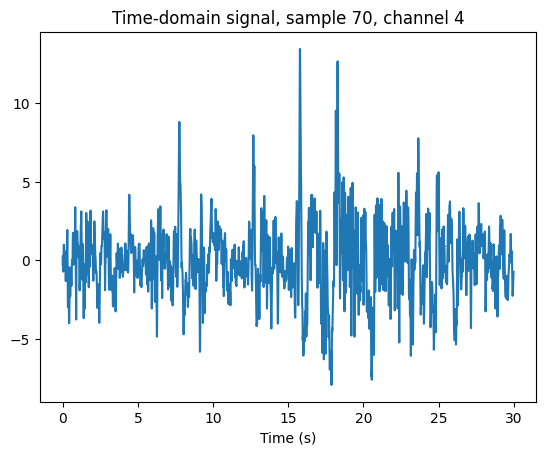

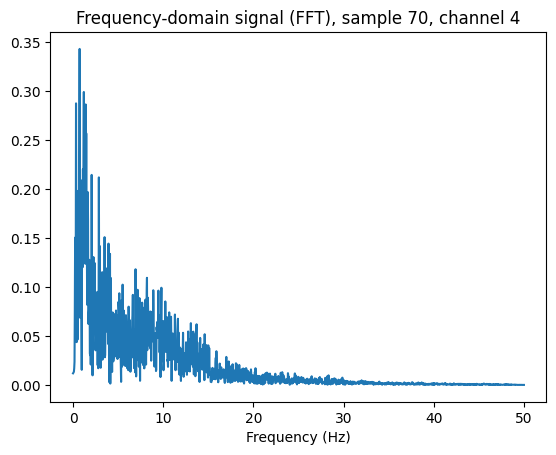

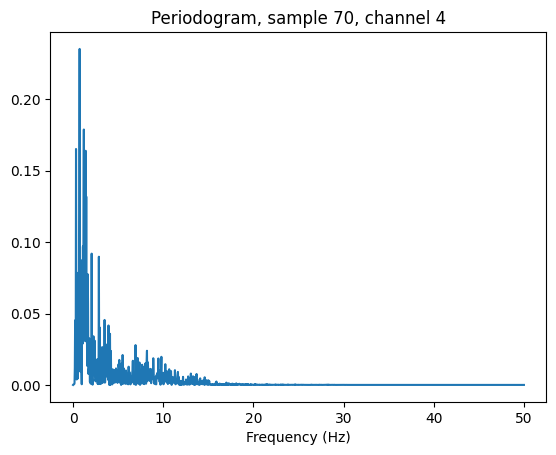

In [12]:
# Select a sample and a measurement channel for the analysis
sample = 70
channel = 4  # 2-7 are the EEG channels

# Plot the time domain signal
plt.plot(time_axis, X_train[sample, channel])
plt.title(f'Time-domain signal, sample {sample}, channel {channel}')
plt.xlabel('Time (s)')
plt.show()

# Frequency axis
N = e_length * sampling_frequency
freq_axis = rfftfreq(N, 1 / sampling_frequency)

# Plot frequency domain signal using fourier transform
plt.plot(freq_axis, 1 / N * np.abs(rfft(X_train[sample, channel])))
plt.title(f'Frequency-domain signal (FFT), sample {sample}, channel {channel}')
plt.xlabel('Frequency (Hz)')
plt.show()

# Use the periodogram function to show power spectral density
freq_axis, spectrum = periodogram(X_train[sample, channel], sampling_frequency, scaling='spectrum')
plt.plot(freq_axis, spectrum)
plt.title(f'Periodogram, sample {sample}, channel {channel}')
plt.xlabel('Frequency (Hz)')
plt.show()

In this particular case, the signal consists of low frequencies and a small peaks at about 10Hz and 15Hz. Since the data is already filtered, we can skip some of the preprocessing steps. Let's see how to extract some handcrafted features from the signals:

In [13]:
zcr = np.nonzero(np.diff(X_train[sample, channel] > 0))[0].size / N
# Zero crossing rate
print(f'Time domain:\nZCR = {zcr:.3f}')
# Signal skewness
print(f'Skewness = {skew(X_train[sample, channel]):.3f}')
# Signal kurtosis
print(f'Kurtosis = {kurtosis(X_train[sample, channel]):.3f}')
print(f'\nFrequency domain:')
# Peak frequency
print(f'Frequency with maximum power = {freq_axis[np.argmax(spectrum)]:.3f}Hz')

Time domain:
ZCR = 0.109
Skewness = 0.464
Kurtosis = 2.757

Frequency domain:
Frequency with maximum power = 0.733Hz


Similar to tutorial 3, we can create a Feature extractor class for the pipeline that can be used to create time- and frequency-domain features from the given epoch.

In [14]:
class FeatureExtractor():
    """
    Class to extract handcrafted features from time and frequency-domain signals.
    """
    def __init__(self, sf=100, e_l=30, cutoff=[1, 49]):
        # Save parameters to the class instance

        # Sampling frequency
        self.sf = sf
        # Epoch length
        self.e_l = e_l

        # Bandpass filtering cutoff frequencies
        self.cutoff = cutoff

        # Constant parameters

        # Number of sampling points
        self.N = self.sf * self.e_l
        # Butterworth filter order
        self.order = 5
        # Amount of features
        self.n_features = 7

    # Just passes data through the feature extractor, no parameters are learned
    def fit(self, X, y=None):
        self.fit_transform(X)
        return self
    # Returns features of the given epoch
    def transform(self, X, y=None):
        return self._extractor(X)
    # Returns features of the given epoch
    def fit_transform(self, X, y=None):
        return self._extractor(X)

    def _extractor(self, signal):
        # Array of multiple signals. Note that multichannel signal is assumed.
        if len(signal.shape) > 2:

            # Empty feature array
            features = np.empty(
                (signal.shape[0], self.n_features * signal.shape[1]))
            
            for id in range(signal.shape[0]):
                features[id, :] = self._calculate_features(signal[id])
            return features
        # Single signal
        else:
            return self._calculate_features(signal)

    # Function to calculate time- and frequency-domain features
    def _calculate_features(self, signal):
        
        # Frequency domain
        freq, spectrum = periodogram(signal, self.sf, scaling='density')
        
        # Calculate channel-wise features
        feature_vector = []

        # Time domain #

        # Signal skewness
        feature_vector.extend(skew(signal, axis=1))

        # Signal kurtosis
        feature_vector.extend(kurtosis(signal, axis=1))

        # Zero crossing rate
        feature_vector.extend(
            np.sum(np.diff(signal > 0, axis=1), axis=1))
        
        # Hjorth mobility
        mobility = self._hjorth_mobility(signal)
        feature_vector.extend(mobility)

        # Hjorth complexity
        feature_vector.extend(
            self._hjorth_mobility(np.diff(signal, axis=1)) / mobility)
            
        # Frequency domain #
        
        # Frequency with maximum power
        feature_vector.extend(freq[np.argmax(spectrum, axis=1)])

        # Spectral entropy
        # Normalized power spectral density
        spectrum /= np.expand_dims(spectrum.sum(axis=1), -1)
        # Entropy
        err = 1e-5  # Account for zero logarithm
        ln = np.where(spectrum == 0, 0, np.log(spectrum + err))
        feature_vector.extend(-np.sum(spectrum * ln, axis=1))
        

        return feature_vector

    # Hjorth mobility parameter
    def _hjorth_mobility(self, fx):
        return np.sqrt(
            np.var(np.diff(fx, axis=1), axis=1) / np.var(fx, axis=1))

We can also use a similar cross-validation loop to tutorial 1. However, we will add group-splits to account for patient ID.

In [15]:
# Training loop
def train_gkfold(feature, target, model_architecture, groups, metric=accuracy_score, 
                 splits=5, threshold=0.5, seed=42):
    """
    Train a model with stratified K-fold cross-validation.

    :param feature: Input for the model
    :param target: Ground truth for the model
    :param model: Scikit-learn model to be trained
    :param groups: Patient ID
    :param metric: Metric to compare the predictions and ground truth
    :param splits: Number of cross-validation splits
    :param threshold: Threshold for binary prediction
    :return: Concatenated model predictions, ground truth and metrics for all folds
    """

    # Split training and validation accounting for patient ID
    gss = GroupShuffleSplit(n_splits=splits,test_size=1/splits, random_state=seed)
    gss.get_n_splits()

    # Initialize lists
    losses, predictions, targets, models = [], [], [], []

    for train_idx, test_idx in gss.split(feature, target, groups):
        features_train = feature[train_idx]
        features_val = feature[val_idx]
        target_train = target[train_idx]
        target_val = target[val_idx]

        # Clone the model architecture (otherwise same model would be trained)
        model = clone(model_architecture)

        # Fit on training data
        model.fit(features_train, target_train)

        # Predict on validation split (multiclass prediction)
        prediction = model.predict(features_val)

        # Estimate performance
        loss = metric(prediction, target_val)

        # Appending to lists
        losses.append(loss)
        predictions.extend(prediction)
        targets.extend(target_val)
        models.append(model)

    # Convert results to array
    predictions = np.array(predictions)
    targets = np.array(targets)

    return predictions, targets, losses, models

Next, we can plug the feature extractor into the scikit-learn pipeline and start training the GBM.

In [18]:
# Handcrafted features
start = time.time()
sleep_clf = Pipeline([
    ('feature_extraction', FeatureExtractor()),
    ('classifier', GradientBoostingClassifier(
        n_estimators=20,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        min_samples_split=5,
        random_state=seed
    ))])

# Cross-validation loop for training
predictions, targets, losses, models = train_gkfold(X_Train, Y_Train, sleep_clf,
                                                    groups, seed=seed, splits=10)

# Multiple test-time predictions
predictions_fe_cv = []
predictions_fe_proba = []
for m in models:
    predictions_fe_cv.append(m.predict(X_test))
    predictions_fe_proba.append(m.predict_proba(X_test))
# Average the prediction probabilities
predictions_fe_proba = np.mean(predictions_fe_proba, axis=0)
# Use the class with maximum probability as the prediction
predictions_fe = np.argmax(predictions_fe_proba, axis=1)
# Correct for target and index inconsistency
predictions_fe[predictions_fe == 4] = 5

# Accuracy and classification report
print(f'Accuracy: {accuracy_score(predictions, targets):.3f}')
print(classification_report(targets, predictions, labels=[0, 1, 2, 3, 5]))

# Create confusion matrix
conf = confusion_matrix(targets, predictions)
true_labels = ['True W', 'True N1', 'True N2', 'True N3', 'True R']
pred_labels = ['Pred W', 'Pred N1', 'Pred N2', 'Pred N3', 'Pred R']
with pd.option_context('display.max_columns', 10):
    print(pd.DataFrame(conf, index=true_labels,
                       columns=pred_labels))

dur = time.time() - start
print(f'Training the model took {dur // 60:.0f} minutes, {dur % 60:.0f} seconds.')

Accuracy: 0.892
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       760
           1       0.96      0.55      0.70       390
           2       0.80      0.93      0.86       890
           3       0.93      0.94      0.94       840
           5       0.98      0.87      0.92       120

    accuracy                           0.89      3000
   macro avg       0.92      0.85      0.87      3000
weighted avg       0.90      0.89      0.89      3000

         Pred W  Pred N1  Pred N2  Pred N3  Pred R
True W      736        1       23        0       0
True N1      47      214      124        5       0
True N2       3        9      829       47       2
True N3       0        0       48      792       0
True R        0        0        8        8     104
Training the model took 1 minutes, 38 seconds.


This time the training was much faster, despite running 10-fold cross-validation instead of one split! The accuracy, classification report and confusion matrix also show much higher performance for all classes. Clearly handcrafted features are much better suited for conventional machine learning models than inputting raw data.

# 5. Class imbalance

We already tested weighted sampling on tutorial 2. However, all classifiers do not include this option and a general all-around method could be useful. The imblearn package allows oversampling the lower frequency classes.

In [19]:
# Oversample the data
sampler = SMOTE(random_state=seed)

# Input should be in two dimensions (sample, signals)
# Oversample the full training data
X_Train_sampled, Y_Train_sampled = sampler.fit_resample(
    X_Train.reshape(X_Train.shape[0], -1), Y_Train)
# Return the original shape for resampled data
X_Train_sampled = X_Train_sampled.reshape(X_Train_sampled.shape[0], 13, -1)

# Oversample the groups variable
groups_sampled, Y_Train_sampled2 = sampler.fit_resample(groups.reshape(-1, 1), Y_Train)
# Verify that the groups_sampled and X_Train_sampled correspond to same classes
np.mean(Y_Train_sampled == Y_Train_sampled2)

1.0

In [20]:
start = time.time()

# Train model on balanced data
sleep_clf = Pipeline([
    ('feature_extraction', FeatureExtractor()),
    ('classifier', GradientBoostingClassifier(
        n_estimators=20,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        min_samples_split=5,
        random_state=seed
    ))])

# Cross-validation loop for training. Note different input data
predictions, targets, losses, models = train_gkfold(X_Train_sampled, 
                                                    Y_Train_sampled, sleep_clf,
                                                    groups_sampled,
                                                    seed=seed, splits=10)

# Multiple test-time predictions
predictions_fe_bal_cv = []
predictions_balanced_proba = []
for m in models:
    predictions_fe_bal_cv.append(m.predict(X_test))
    predictions_balanced_proba.append(m.predict_proba(X_test))
# Average the prediction probabilities
predictions_balanced_proba = np.mean(predictions_balanced_proba, axis=0)
# Use the class with maximum probability as the prediction
predictions_fe_bal = np.argmax(predictions_balanced_proba, axis=1)
# Correct for target and index inconsistency
predictions_fe_bal[predictions_fe_bal == 4] = 5

# Cross-validation results
print(f'Accuracy: {accuracy_score(predictions, targets):.3f}')
print(classification_report(targets, predictions, labels=[0, 1, 2, 3, 5]))

# Create confusion matrix
conf = confusion_matrix(targets, predictions)
true_labels = ['True W', 'True N1', 'True N2', 'True N3', 'True R']
pred_labels = ['Pred W', 'Pred N1', 'Pred N2', 'Pred N3', 'Pred R']
with pd.option_context('display.max_columns', 10):
    print(pd.DataFrame(conf, index=true_labels,
                       columns=pred_labels))

dur = time.time() - start
print(f'Training the model took {dur // 60:.0f} minutes, {dur % 60:.0f} seconds.')

Accuracy: 0.869
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       760
           1       0.71      0.66      0.68       390
           2       0.83      0.87      0.85       890
           3       0.93      0.93      0.93       840
           5       0.80      0.94      0.86       120

    accuracy                           0.87      3000
   macro avg       0.84      0.86      0.85      3000
weighted avg       0.87      0.87      0.87      3000

         Pred W  Pred N1  Pred N2  Pred N3  Pred R
True W      682       58       19        1       0
True N1      30      257       97        5       1
True N2       9       46      770       51      14
True N3       0        3       39      784      14
True R        0        0        5        2     113
Training the model took 1 minutes, 50 seconds.


The oversampling seems to yield slightly lower performance on validation results.

# 6. Performance evaluation

Now that we have trained the different models, we can evaluate their performance on the test set.

In this case, we have an entirely different test set compared to training. The models were trained on healthy controls 10-fold cross-validation (leave-one-patient-out) and the test set consists of 9 sleep disorder patients. This is a good check to see if our model generalizes on distinct signals.

In [23]:
# DO NOT RUN THIS CELL

# Predictions from the 39 000-feature model 
print('39 000 features:')
print(f'Accuracy: {accuracy_score(predictions_bline, Y_test):.3f}')
print(classification_report(Y_test, predictions_bline, labels=[0, 1, 2, 3, 5]))
print('Confusion matrix: \n', 
      pd.DataFrame(confusion_matrix(Y_test, predictions_bline), 
                   index=true_labels, columns=pred_labels))

39 000 features:
Accuracy: 0.551
              precision    recall  f1-score   support

           0       0.60      0.79      0.69       243
           1       0.50      0.04      0.07       103
           2       0.43      0.48      0.45       275
           3       0.61      0.71      0.65       211
           5       0.76      0.28      0.41        68

    accuracy                           0.55       900
   macro avg       0.58      0.46      0.45       900
weighted avg       0.55      0.55      0.52       900

Confusion matrix: 
          Pred W  Pred N1  Pred N2  Pred N3  Pred R
True W      193        1       42        7       0
True N1      49        4       45        2       3
True N2      59        1      131       81       3
True N3      17        0       45      149       0
True R        2        2       39        6      19


In [26]:
print('\n____________\nFeature extraction:')
print(f'Accuracy: {accuracy_score(predictions_fe, Y_test):.3f}')
print(classification_report(Y_test, predictions_fe, labels=[0, 1, 2, 3, 5]))
print('Confusion matrix: \n', 
      pd.DataFrame(confusion_matrix(Y_test, predictions_fe), 
                   index=true_labels, columns=pred_labels))

print('\n____________\nBalanced Feature extraction:')
print(f'Accuracy: {accuracy_score(predictions_fe_bal, Y_test):.3f}')
print(classification_report(Y_test, predictions_fe_bal, labels=[0, 1, 2, 3, 5]))
print('Confusion matrix: \n', 
      pd.DataFrame(confusion_matrix(Y_test, predictions_fe_bal),
                   index=true_labels, columns=pred_labels))


____________
Feature extraction:
Accuracy: 0.683
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       243
           1       0.38      0.30      0.34       103
           2       0.62      0.59      0.60       275
           3       0.72      0.91      0.80       211
           5       0.75      0.65      0.69        68

    accuracy                           0.68       900
   macro avg       0.65      0.64      0.64       900
weighted avg       0.67      0.68      0.68       900

Confusion matrix: 
          Pred W  Pred N1  Pred N2  Pred N3  Pred R
True W      188       15       29        7       4
True N1      30       31       35        7       0
True N2      12       30      161       61      11
True N3       0        0       20      191       0
True R        3        5       16        0      44

____________
Balanced Feature extraction:
Accuracy: 0.676
              precision    recall  f1-score   support

           0       0.

From the results on the test set, we can see that:

- **Handcrafted features** outperform training the classifier on raw signals
- The performance decreased quite a lot compared to validation results. This could be due to overfitting on cross-validation.
- **Class balancing** (oversampling) did not increase the overall performance. However, it could improve performance on the classes with less samples.

But how do we know which accuracy or performance score is good enough? Many machine learning studies are often criticized for their performance evaluation, for example if the researchers report a couple of decimals performance increase to the previous method. Luckily, we have the sleep scores from two readers, and we can compare the model predictions to the **inter-rater variability** (check if the two readers agree with each other).

In [27]:
reader_1 = np.append(labels_c[:, 0, :].flatten(), labels_p[:, 0, :].flatten())
reader_2 = np.append(labels_c[:, 1, :].flatten(), labels_p[:, 1, :].flatten())
reader_1_c = labels_c[:, 0, :].flatten()
reader_2_c = labels_c[:, 1, :].flatten()
reader_1_p = labels_p[:, 0, :].flatten()
reader_2_p = labels_p[:, 1, :].flatten()

r1_labels = ['Rdr1: W', 'Rdr1: N1', 'Rdr1: N2', 'Rdr1: N3', 'Rdr1: R']
r2_labels = ['Rdr2: W', 'Rdr2: N1', 'Rdr2: N2', 'Rdr2: N3', 'Rdr2: R']

print('Inter-reader accuracy (controls+patients):')
print(f'Accuracy: {accuracy_score(reader_1, reader_2):.3f}')
print(classification_report(reader_1, reader_2, labels=[0, 1, 2, 3, 5]))
print('Confusion matrix: \n', 
      pd.DataFrame(confusion_matrix(reader_1, reader_2),
                   index=r1_labels, columns=r2_labels))

print('\n____________\nInter-reader accuracy (controls):')
print(f'Accuracy: {accuracy_score(reader_1_c, reader_2_c):.3f}')
print(classification_report(reader_1_c, reader_2_c, labels=[0, 1, 2, 3, 5]))
print('Confusion matrix: \n', 
      pd.DataFrame(confusion_matrix(reader_1_c, reader_2_c),
                   index=r1_labels, columns=r2_labels))

print('\n____________\nInter-reader accuracy (patients):')
print(f'Accuracy: {accuracy_score(reader_1_p, reader_2_p):.3f}')
print(classification_report(reader_1_p, reader_2_p, labels=[0, 1, 2, 3, 5]))
print('Confusion matrix: \n', 
      pd.DataFrame(confusion_matrix(reader_1_p, reader_2_p),
                   index=r1_labels, columns=r2_labels))

Inter-reader accuracy (controls+patients):
Accuracy: 0.859
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       484
           1       0.76      0.53      0.62       226
           2       0.78      0.85      0.81       555
           3       0.87      0.91      0.89       485
           5       0.88      0.99      0.93       150

    accuracy                           0.86      1900
   macro avg       0.85      0.84      0.84      1900
weighted avg       0.86      0.86      0.86      1900

Confusion matrix: 
           Rdr2: W  Rdr2: N1  Rdr2: N2  Rdr2: N3  Rdr2: R
Rdr1: W       450        24        10         0        0
Rdr1: N1       10       120        80         0       16
Rdr1: N2        2        13       471        65        4
Rdr1: N3        2         0        40       443        0
Rdr1: R         0         1         1         0      148

____________
Inter-reader accuracy (controls):
Accuracy: 0.880
              precision   

We can immediately see that the readers have quite consistent predictions with high inter-rater agreement. The wake-state and REM-state are the easiest to classify for the professional reader, whereas the N1-state is the most difficult. **Also, the sleep stages of the healthy controls are easier to classify than that for the sleep-disorder patients**.

However, REM sleep was quite difficult to detect with the automatic pipeline. This could maybe be explained by the fact that each epoch was assessed independently. A model with information from previous epochs could provide more reliable estimate of the sleep stage.

To analyze the performance more carefully, we could plot the Receiving operating characteristic (**ROC**) and precision-recall (**PRC**) curves as in tutorial 1. This time, we will run the analysis for **multiple classes**, and include **confidence intervals** to the metrics using **bootstrapping**. Finally, we will include the reader accuracy in the ROC curve to estimate how human performance compares to the predictions. 

Bootstrapping is a resampling method where random samples are drawn with replacement. When the metric is evaluated multiple times for the random samples, we can get an estimate of its statistical distribution, allowing the estimation of confidence intervals. However, it should be noted that bootstrapping has also disadvantages, such as assumption of independent samples and that the samples are representative.

In [28]:
def calc_curve_bootstrap(y, preds, curve=roc_curve, metric=roc_auc_score, 
                         n_bootstrap=1000, bag_size=0.5, seed=5, 
                         stratified=True, alpha=95):
    """
    Calculate metric values and curve values using bootstrapping. 
    Examples include ROC and PRC curve analysis.
    Parameters
    ----------
    curve : function
        Function, which computes the curve.
    metric : fucntion
        Metric to compute, e.g. AUC for ROC curve or AP for PR curve
    y : numpy.array
        Ground truth
    preds : numpy.array
        Predictions
    n_bootstrap:
        Number of bootstrap samples to draw
    bag_size:
        Proportion of samples in one bootstrapping bag 
        (note that they are drawn with replacement, and bag_size=1 
        does not necessarily include all samples)
    seed : int
        Random seed
    stratified : bool
        Whether to do a stratified bootstrapping
    alpha : float
        Confidence interval width
    """

    np.random.seed(seed)
    metric_vals = []
    ind_pos = np.where(y == 1)[0]
    ind_neg = np.where(y == 0)[0]

    # Bootstrap the metric
    for _ in range(n_bootstrap):
        if stratified:
            ind_pos_bs = np.random.choice(ind_pos, int(ind_pos.shape[0] * bag_size))
            ind_neg_bs = np.random.choice(ind_neg, int(ind_neg.shape[0] * bag_size))
            ind = np.hstack((ind_pos_bs, ind_neg_bs))
        else:
            ind = np.random.choice(y.shape[0], int(y.shape[0] * bag_size))

        if y[ind].sum() == 0:
            continue
        metric_vals.append(metric(y[ind], preds[ind]))

    metric_val = np.mean(metric_vals)
    x_curve, y_curve, _ = curve(y, preds)

    # Confidence intervals
    ci_l = np.percentile(metric_vals, (100 - alpha) // 2)
    ci_h = np.percentile(metric_vals, alpha + (100 - alpha) // 2)

    return metric_val, ci_l, ci_h, x_curve, y_curve, metric_vals


def confidence_interval(array):
    """Returns 95% confidence intervals, assuming normal distribution."""
    mean, std = np.mean(array), np.std(array)
    n = len(array)
    return mean - 1.96 * std / np.sqrt(n), mean + 1.96 * std / np.sqrt(n)

AUC (class 0): 0.95, [0.92, 0.96]
AUC (class 1): 0.82, [0.76, 0.87]
AUC (class 2): 0.86, [0.82, 0.89]
AUC (class 3): 0.97, [0.96, 0.98]
AUC (class 5): 0.93, [0.87, 0.97]


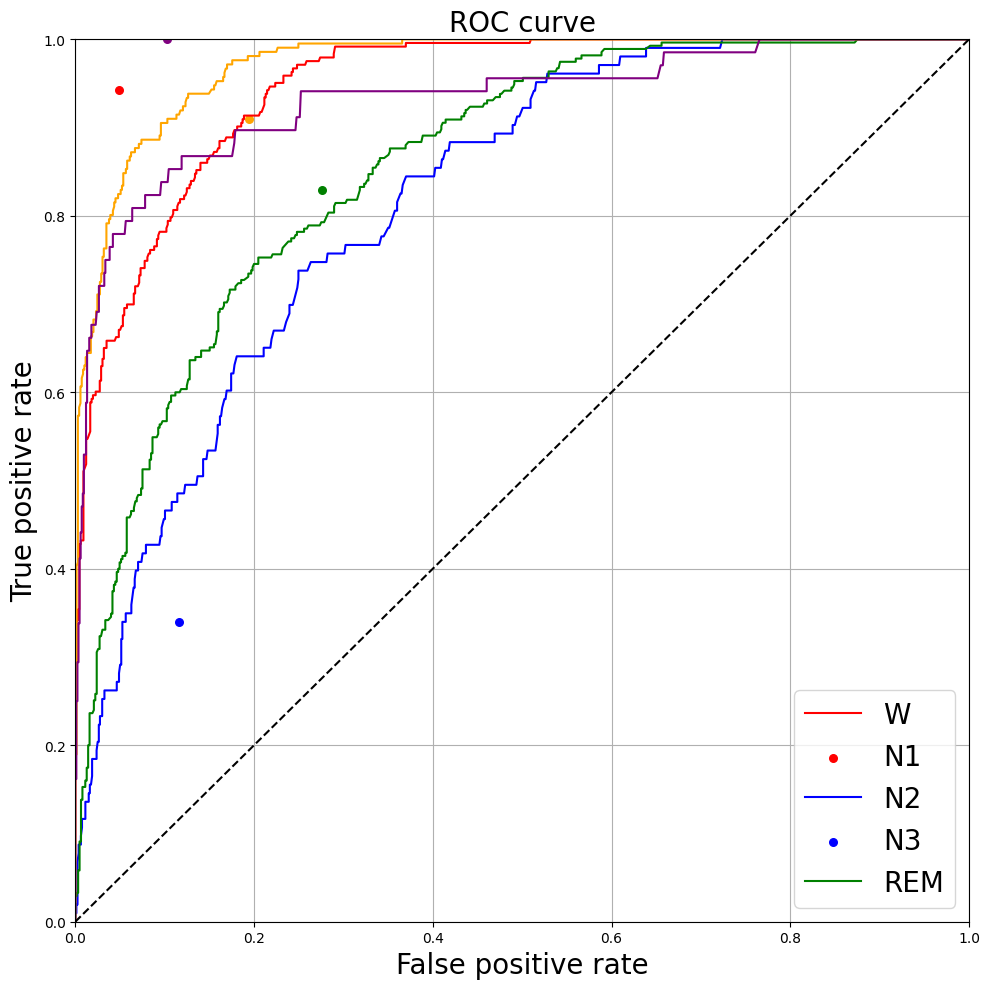

In [29]:
# ROC curve
fprs, tprs = [], []
classes = np.unique(Y_test)
for stage in range(len(classes)):
    # Calculate the values
    auc, cil, cih, fpr, tpr, _ = calc_curve_bootstrap(
        Y_test == classes[stage], predictions_fe_proba[:, stage], stratified=True)
    fprs.append(fpr)
    tprs.append(tpr)

    print('AUC (class {0:.0f}): {1:.2f}, [{2:.2f}, {3:.2f}]'
        .format(classes[stage],auc, cil, cih))

# Plot ROC curve
colors = ['red', 'blue', 'green', 'orange', 'purple']
fig = plt.figure(figsize=(10, 10))
for stage in range(len(fprs)):
    plt.plot(fprs[stage], tprs[stage], colors[stage])

    # Confusion matrix for the readers
    tn, fp, fn, tp = confusion_matrix(
        reader_1_p == classes[stage], reader_2_p == classes[stage]).ravel()
    # Plot the reader performance (FPR and TPR)
    plt.scatter(fp / (tp + fn), tp / (tp + fn), color=colors[stage], s=30)

plt.title('ROC curve', fontsize=20)
class_names = ['W', 'N1', 'N2', 'N3', 'REM']
plt.plot([0, 1], [0, 1], '--', color='black')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)

plt.legend(class_names, fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

Here we can see performance on each individual class plotted on the same graph. Inter-reader agreement is shown as a large dot of the corresponding color. Looking at the ROC curve, we can see that the human performance is mostly exceeding the machine learning model (perfect classification at the top left corner). However, the difficult N1-stage is slightly better classified by the model.

AP (class 0): 0.88, [0.83, 0.92]
AP (class 1): 0.40, [0.29, 0.51]
AP (class 2): 0.72, [0.64, 0.79]
AP (class 3): 0.92, [0.88, 0.95]
AP (class 5): 0.74, [0.59, 0.85]


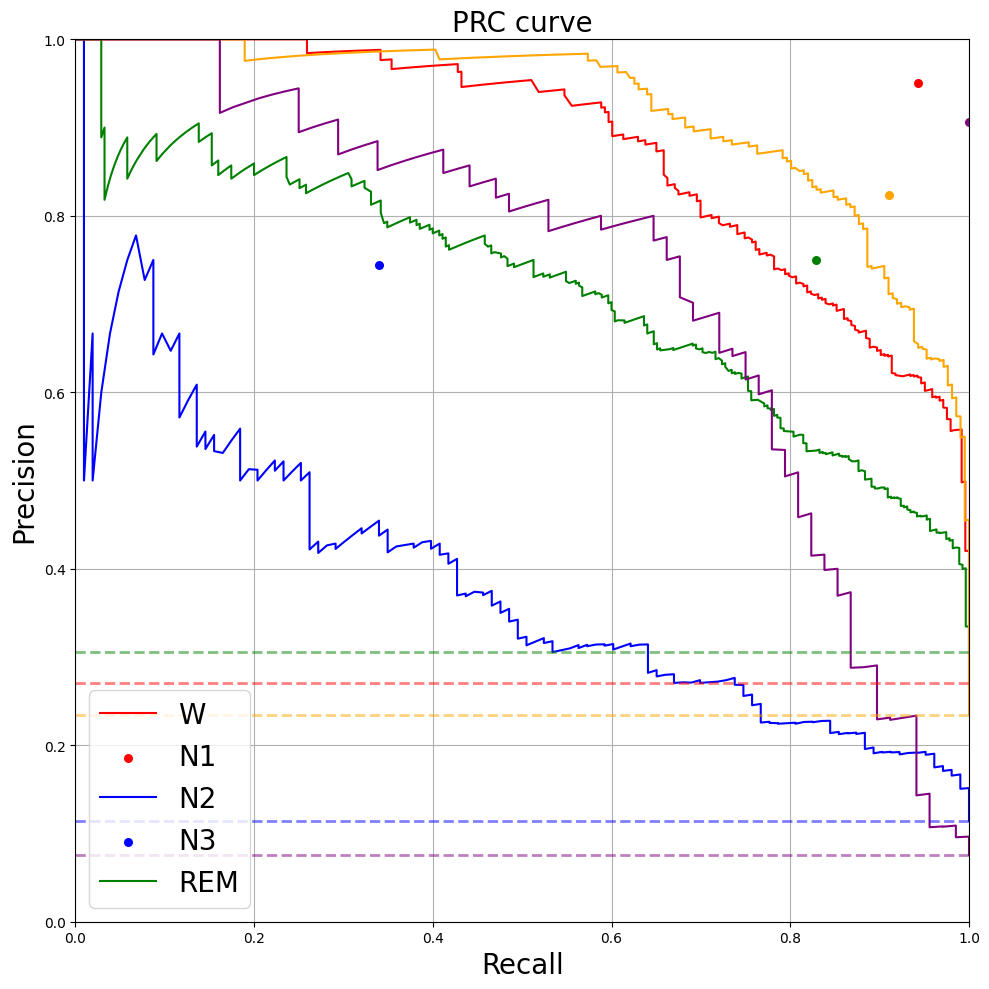

In [30]:
# PRC curve
prcs, recs = [], []
for stage in range(len(classes)):
    # Calculate the values
    ap, cil, cih, prc, rec, _ = calc_curve_bootstrap(
        Y_test == classes[stage], predictions_fe_proba[:, stage], metric=
        average_precision_score, curve=precision_recall_curve, stratified=True)
    prcs.append(prc)
    recs.append(rec)

    print('AP (class {0:.0f}): {1:.2f}, [{2:.2f}, {3:.2f}]'
        .format(classes[stage], ap, cil, cih))

# Plot PRC curve
fig = plt.figure(figsize=(10, 10))
baselines = []
for stage in range(len(fprs)):
    plt.plot(recs[stage], prcs[stage], colors[stage])

    # Confusion matrix for the readers
    tn, fp, fn, tp = confusion_matrix(
        reader_1_p == classes[stage], reader_2_p == classes[stage]).ravel()
    # Plot the reader performance (PRC and REC)
    positives = tp + fn
    negatives = fp + tn
    plt.scatter(tp / (tp + fn), tp / (tp + fp), color=colors[stage], s=30)

    
    baselines.append(positives / (positives + negatives))

plt.title('PRC curve', fontsize=20)
plt.legend(class_names, loc='lower left', fontsize=20)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)

# Precision recall baseline for random guess
for stage in range(len(fprs)):
    baseline = baselines[stage]
    plt.plot([0, 1], [baseline, baseline], '--', 
         color=colors[stage], alpha=0.5, linewidth=2)

plt.grid()
plt.tight_layout()
plt.show()

As We can recall from tutorial 1, PRC curves should be used in case the dataset is imbalanced. When considering single sleep stages, there is a heavy imbalance, since all the other classes are included in the "negative" class.

The PRC plot shows that precision and recall are much higher with the human readers in all cases.

# 7. Statistical testing

The results from balanced sampling and the plain feature extractor were very close to each other. To estimate if one model choice is better or differences are due to chance, we can use statistical methods.

Using the bootstrapping function from previous section, we can see if the confidence intervals overlap between the two models:


In [31]:
metrics_unbalanced, metrics_balanced = [], []
for stage in range(len(classes)):
    # Calculate the values
    ap, cil, cih, _, _, metric_vals = calc_curve_bootstrap(
        Y_test == classes[stage], predictions_fe_proba[:, stage], metric=
        average_precision_score, curve=precision_recall_curve, stratified=True,
        seed=seed)

    metrics_unbalanced.append(metric_vals)    
    print('AP (class {0:.0f}, unbalanced sampling): {1:.2f}, [{2:.2f}, {3:.2f}]'
        .format(classes[stage], ap, cil, cih))

    # Calculate the values
    ap, cil, cih, _, _, metric_vals = calc_curve_bootstrap(
        Y_test == classes[stage], predictions_balanced_proba[:, stage], metric=
        average_precision_score, curve=precision_recall_curve, stratified=True, 
        seed=seed)

    metrics_balanced.append(metric_vals) 
    print('AP (class {0:.0f}, balanced sampling): {1:.2f}, [{2:.2f}, {3:.2f}]'
        .format(classes[stage], ap, cil, cih))

AP (class 0, unbalanced sampling): 0.88, [0.83, 0.92]
AP (class 0, balanced sampling): 0.89, [0.85, 0.93]
AP (class 1, unbalanced sampling): 0.40, [0.29, 0.51]
AP (class 1, balanced sampling): 0.42, [0.29, 0.53]
AP (class 2, unbalanced sampling): 0.72, [0.64, 0.79]
AP (class 2, balanced sampling): 0.72, [0.65, 0.79]
AP (class 3, unbalanced sampling): 0.92, [0.88, 0.95]
AP (class 3, balanced sampling): 0.91, [0.88, 0.95]
AP (class 5, unbalanced sampling): 0.74, [0.59, 0.85]
AP (class 5, balanced sampling): 0.70, [0.55, 0.82]


It seems that the confidence intervals acquired by bootstrapping the test predictions are quite wide. This would suggest that there is a lot of random variation in the predictions. 

As we can see, the differences between the models are quite small. There is a slight difference on the N1 and REM stages, but is it due to random variation or the difference between the models?

Besides bootstrapping, we can estimate the differences of unbalanced and balanced sampling by using the cross-validation folds:

In [32]:
for stage in classes:
    aps, aucs = [], []
    for idx in range(len(predictions_fe_cv)):
        aucs.append([roc_auc_score(predictions_fe_cv[idx] == stage, Y_test == stage),
                    roc_auc_score(predictions_fe_bal_cv[idx] == stage, Y_test == stage),])
        aps.append([average_precision_score(predictions_fe_cv[idx] == stage, Y_test == stage),
                    average_precision_score(predictions_fe_bal_cv[idx] == stage, Y_test == stage),])
        
    # Mean metrics
    auc_mean = (np.mean(np.array(aucs)[:, 0]), np.mean(np.array(aucs)[:, 1]))
    ap_mean = (np.mean(np.array(aps)[:, 0]), np.mean(np.array(aps)[:, 1]))

    # 95% Confidence intervals
    ci_auc = confidence_interval(np.array(aucs)[:, 0])
    ci_auc_bal = confidence_interval(np.array(aucs)[:, 1])
    ci_ap = confidence_interval(np.array(aps)[:, 0])
    ci_ap_bal = confidence_interval(np.array(aps)[:, 1])

    # Display mean and CIs
    print(f'Class {stage:.0f}')
    print('Mean AUC (unbalanced): {:.2f} [{:.2f}, {:.2f}], (balanced): {:.2f} [{:.2f}, {:.2f}]'.format(
        auc_mean[0], ci_auc[0], ci_auc[1], auc_mean[1], ci_auc_bal[0], ci_auc_bal[1]
    ))
    print('Mean AP (unbalanced): {:.2f} [{:.2f}, {:.2f}], (balanced): {:.2f} [{:.2f}, {:.2f}]'.format(
        ap_mean[0], ci_ap[0], ci_ap[1], ap_mean[1], ci_ap_bal[0], ci_ap_bal[1]
    ))

    # Wilcoxon test for the p-value
    stats_auc, p_auc = wilcoxon(np.array(aucs)[:, 0], np.array(aucs)[:, 1])
    stats_ap, p_ap = wilcoxon(np.array(aps)[:, 0], np.array(aps)[:, 1])
    print(f'Difference in AUC (p-value): {p_auc:.5f}')  
    print(f'Difference in AP (p-value): {p_ap:.5f}\n')  


Class 0
Mean AUC (unbalanced): 0.86 [0.85, 0.87], (balanced): 0.89 [0.89, 0.90]
Mean AP (unbalanced): 0.67 [0.66, 0.68], (balanced): 0.66 [0.63, 0.68]
Difference in AUC (p-value): 0.00195
Difference in AP (p-value): 0.32227

Class 1
Mean AUC (unbalanced): 0.64 [0.63, 0.65], (balanced): 0.64 [0.63, 0.65]
Mean AP (unbalanced): 0.17 [0.15, 0.19], (balanced): 0.26 [0.24, 0.29]
Difference in AUC (p-value): 0.92188
Difference in AP (p-value): 0.00391

Class 2
Mean AUC (unbalanced): 0.73 [0.72, 0.73], (balanced): 0.72 [0.71, 0.73]
Mean AP (unbalanced): 0.47 [0.45, 0.48], (balanced): 0.41 [0.39, 0.43]
Difference in AUC (p-value): 0.43164
Difference in AP (p-value): 0.00195

Class 3
Mean AUC (unbalanced): 0.84 [0.84, 0.85], (balanced): 0.85 [0.85, 0.85]
Mean AP (unbalanced): 0.74 [0.73, 0.74], (balanced): 0.74 [0.73, 0.74]
Difference in AUC (p-value): 0.03711
Difference in AP (p-value): 0.62500

Class 5
Mean AUC (unbalanced): 0.83 [0.82, 0.85], (balanced): 0.77 [0.76, 0.78]
Mean AP (unbalanced)

Comparing the models using cross-validation mean and confidence intervals of the cross-validation folds, we can see that the methods are very similar. However, there is a large difference on the N1-stage with both AUC and AP (differences on W and N2 can also be seen). This can also be seen for AP with the Wilcoxon test, yielding low p-values (much lower than 0.05).

# Conclusion

The results would suggest that the balanced model is better for classifying N1, but the unbalanced might be slightly better for detecting W, N2 or REM stages. No differences are seen in the N3 stage. 

Our results were not close to **human performance**. To improve the model predictions, more handcrafted features, and regularization could have been added. Modern **deep learning** methods, such as convolutional neural networks, have also shown excellent performance (sometimes even exceeding human level performance) when large amounts of training data are available.

After finishing this tutorial you should have learned the basics for conducting **machine learning experiments on signals**. We also covered how to use **oversampling to account for class imbalance**, **comparing the model predictions to human performance**, and evaluating the results using **statistical methods**.

Thank you for attending the course tutorials! Please remember to give course feedback at [palaute.oulu.fi](https://palaute.oulu.fi/).